<a href="https://colab.research.google.com/github/yoo9519-AIdev/SNU_AI/blob/main/EfficientNet_B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet_B7
- Dataset : Chest_Xray8  
- feature_names : over 500  
- Weights : imagenet
- Last Date : 2020.11.16.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


------------------------------------------

### 필요모듈 호출 Tensorflow version확인 및 GPU 사용가능여부 확인

In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.3.0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5124366739272101633, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9458296188438341554
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14302799191173604526
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14931171264703828417
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

-------

### Data 경로지정 image 수 확인 / Preprocessing

In [ ]:
DATA_DIR = 'C:/Users/Research/anaconda3/Visual_Pyhton3/all_image'
# DATA_DIR2 = '../input/chest-xray-pneumonia/'
image_size = 224
batch_size = 32

In [ ]:
df = pd.read_csv(f'C:/Users/Research/anaconda3/Visual_Pyhton3/Data_Entry_2017.csv')
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [ ]:
from glob import glob
image_len = glob('C:/Users/Research/anaconda3/Visual_Pyhton3/all_image/*.png')
len(image_len)

112120

In [ ]:
# data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}
data_image_paths = {os.path.basename(x): x for x in image_len}
df['path'] = df['Image Index'].map(data_image_paths.get)
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [ ]:
normal_images = glob('C:/Users/Research/anaconda3/Visual_Pyhton3/all_image/*.png')
normal_data = {'path': normal_images, 'Finding Labels': 'Normal'}
df1 = pd.DataFrame(normal_data)
df = pd.concat([df,df1], ignore_index=True, axis=1)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal
112116,00030802_000.png,,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal
112117,00030803_000.png,,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal
112118,00030804_000.png,,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,C:/Users/Research/anaconda3/Visual_Pyhton3/all...,Normal


In [ ]:
df.pop(11)
df.pop(13)
df.pop(14)
df

,0,1,2,3,4,5,6,7,8,9,10,12
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,C:/Users/Research/anaconda3/Visual_Pyhton3/all...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,C:/Users/Research/anaconda3/Visual_Pyhton3/all...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/all...
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,0.171,C:/Users/Research/anaconda3/Visual_Pyhton3/all...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,C:/Users/Research/anaconda3/Visual_Pyhton3/all...
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/all...
112116,00030802_000.png,,0,30802,29,M,PA,2048,2500,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/all...
112117,00030803_000.png,,0,30803,42,F,PA,2048,2500,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/all...
112118,00030804_000.png,,0,30804,30,F,PA,2048,2500,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/all...


In [ ]:
labels = np.unique(list(chain(*df[1].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
for label in labels:
    if len(label) > 1:
        df[label] = df[1].map(lambda finding: 1.0 if label in finding else 0.0)

In [ ]:
labels = [label for label in labels if df[label].sum() > 1000]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

-------

### flow_from_DataFrame 사용준비 및 학습준비과정

In [ ]:
# 실험요소 stratify를 주요 병명 / 전체 병명 두 번에 걸쳐서 실험
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df[1].map(lambda x: x[:4]))

In [ ]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
29770,00007736_000.png,,0,7736,30,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75645,00018562_005.png,,5,18562,30,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94196,00023993_000.png,,0,23993,52,M,PA,2828,2330,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111240,00030381_000.png,,0,30381,21,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85533,00021086_007.png,Consolidation|Nodule,7,21086,62,M,PA,2862,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10526,00002722_007.png,,7,2722,41,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106151,00028576_001.png,,1,28576,27,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69825,00017210_003.png,,3,17210,58,F,PA,2778,2825,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60848,00015028_000.png,,0,15028,53,M,PA,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
valid_df

,0,1,2,3,4,5,6,7,8,9,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
77705,00019093_000.png,Pneumothorax,0,19093,38,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21862,00005793_004.png,Infiltration|Mass|Nodule,4,5793,22,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
44769,00011509_000.png,Effusion,0,11509,45,M,PA,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104264,00027851_000.png,,0,27851,41,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110267,00030028_000.png,,0,30028,69,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34165,00008950_001.png,,1,8950,51,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71213,00017555_005.png,,5,17555,67,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58669,00014525_004.png,,4,14525,57,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75492,00018527_001.png,Atelectasis|Consolidation|Nodule,1,18527,55,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# 파라미터 변경 값 : fill_mode를 reflect로 혹은 wrap으로

core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  rotation_range=10,
                                  shear_range=0.1,
                                  fill_mode='nearest',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col=12,
                                             y_col=1,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col=12,
                                             y_col=1,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col=12,
                                                       y_col=1,
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 24673 validated image filenames belonging to 13 classes.
Found 6180 validated image filenames belonging to 13 classes.
Found 6180 validated image filenames belonging to 13 classes.


--------

### 적용 및 함수지정 / Training

In [ ]:
# GlobalAveragePooling2D 다음에 Flatten() 층을 쌓았더니 최초 loss가 0.8
# 단순 GlobalAveragePooling2D로만 진행했을 때, 최초 loss 0.7

from tensorflow.keras.applications import EfficientNetB7

enet = tf.keras.applications.EfficientNetB7(
        input_shape=(image_size, image_size, 3),
        weights='imagenet',
        include_top=False,
    )

enet.trainable = True

model = tf.keras.Sequential([
    enet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(labels), activation='sigmoid')])

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['AUC','Precision','Recall'])

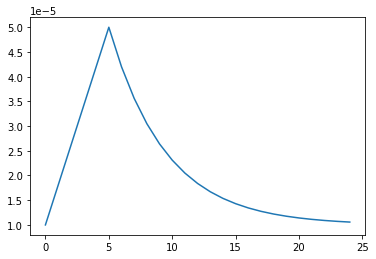

In [ ]:
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)

In [ ]:
def get_callbacks(model_name):
    callbacks = []
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'model.{model_name}.h5',
        verbose=1,
        save_best_only=True)
    
    erly = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1) # 3번 허용. 1~2번은 너무 overfitting 가능성..
    callbacks.append(checkpoint)
    callbacks.append(erly)
    callbacks.append(lr_callback)
    return callbacks

In [ ]:
callbacks = get_callbacks('EfficientB7')
history = model.fit(train_gen,
                   steps_per_epoch = 150, # 150으로 진행
                   validation_data = test_gen,
                   validation_steps = 70,
                   epochs = 25,
                   callbacks = callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
150/150 [==============================] - ETA: 0s - loss: 0.6059 - auc: 0.5643 - precision: 0.0970 - recall: 0.3127  
Epoch 00001: val_loss improved from inf to 0.47478, saving model to model.EfficientB7.h5
150/150 [==============================] - 12883s 86s/step - loss: 0.6059 - auc: 0.5643 - precision: 0.0970 - recall: 0.3127 - val_loss: 0.4748 - val_auc: 0.6856 - val_precision: 0.2796 - val_recall: 0.2201

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/25
150/150 [==============================] - ETA: 0s - loss: 0.3093 - auc: 0.6636 - precision: 0.2424 - recall: 0.0083  
Epoch 00002: val_loss improved from 0.47478 to 0.27928, saving model to model.EfficientB7.h5
150/150 [==============================] - 12445s 83s/step - loss: 0.3093 - auc: 0.6636 - precision: 0.2424 - recall: 0.0083 - val_loss: 0.2793 - val_auc: 0.7255 - val_precision: 0.0000e+00 - val_

----

### 세부결과 및 AUC Curve 확인

In [ ]:
y_pred = model.predict(test_X)

In [ ]:
for label, p_count, t_count in zip(labels,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))

Atelectasis: actual: 13.48%, predicted: 7.12%
Cardiomegaly: actual: 3.52%, predicted: 2.03%
Consolidation: actual: 3.81%, predicted: 4.69%
Edema: actual: 1.86%, predicted: 2.93%
Effusion: actual: 13.77%, predicted: 7.21%
Emphysema: actual: 2.15%, predicted: 2.20%
Fibrosis: actual: 2.73%, predicted: 1.30%
Infiltration: actual: 29.79%, predicted: 54.16%
Mass: actual: 7.32%, predicted: 3.57%
Nodule: actual: 8.69%, predicted: 8.03%
Pleural_Thickening: actual: 3.71%, predicted: 2.68%
Pneumonia: actual: 0.68%, predicted: 1.19%
Pneumothorax: actual: 8.50%, predicted: 4.20%


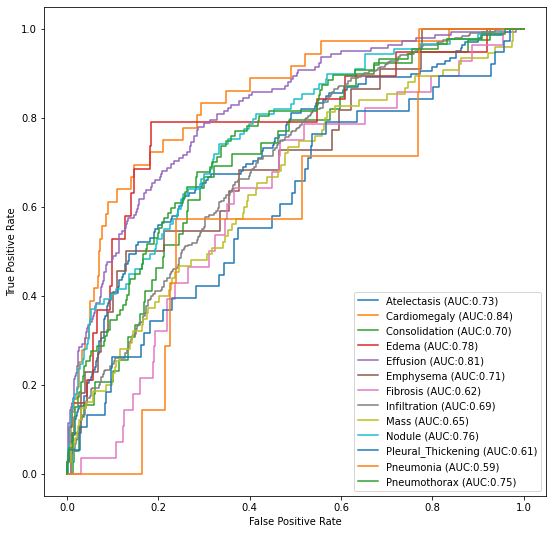

In [ ]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))

for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
print('ROC auc score: {:.3f}'.format(roc_auc_score(test_Y.astype(int), y_pred)))

ROC auc score: 0.711


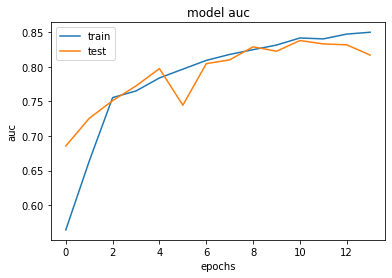

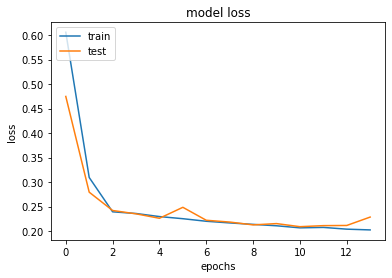

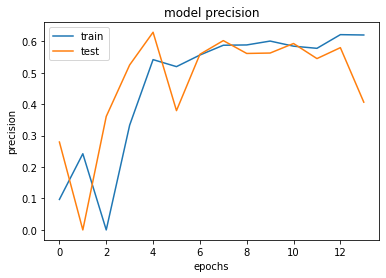

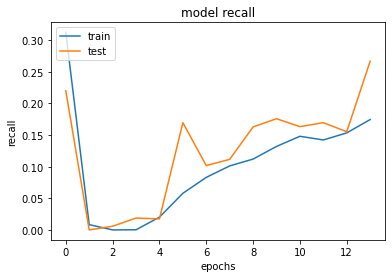

In [ ]:
plt.plot(history.history['auc']) 
plt.plot(history.history['val_auc']) 
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

plt.plot(history.history['recall']) 
plt.plot(history.history['val_recall']) 
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Discussion

No_pretrained : 0.65 (5 epochs에 earlystopping)  
Used_pretrained(imagenet) : 0.80 Predict ?